# (23) Simulation -- self-motion aspect (draft)

**Motivation**: Finalize self motion (this is a draft, exploring the behavior). <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def show_thetaphi():
    fig, axes = create_figure(1, 4, (13, 2.5), tight_layout=True)
    im = axes[0].imshow(theta[valid][:, valid].astype(float), cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[0])

    im = axes[2].imshow(phi[valid][:, valid].astype(float), cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[2])

    for ax in [axes[0], axes[2]]:
        ax.invert_yaxis()
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=ticks,
            yticks=ticks,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
        )

    axes[1].axvline(np.deg2rad(fov), color='r', ls='--', label=f'{fov} deg')
    sns.histplot(
        theta[valid][:, valid].ravel(), ax=axes[1], label=r'$\theta$',
        bins=np.linspace(0, np.pi/2, 91), stat='percent')
    sns.histplot(phi[valid][:, valid].ravel(), ax=axes[3], label=r'$\phi$',
                 bins=np.linspace(0, 2*np.pi, 91), stat='percent')
    for ax in [axes[1], axes[3]]:
        ax.set_ylabel('')
        ax.legend(loc='upper left')

    plt.show()

In [3]:
# HIDE CODE


from scipy.spatial.transform import Rotation as rot


def cart2polar(e):
    e, shape = _check_input(e)
    r = sp_lin.norm(e, ord=2, axis=-1)
    theta = np.arccos(e[:, 2] / r)
    phi = np.arctan2(e[:, 1], e[:, 0])
    phi[phi < 0] += 2 * np.pi
    out = np.concatenate([
        np.expand_dims(r, -1),
        np.expand_dims(theta, -1),
        np.expand_dims(phi, -1),
    ], axis=-1)
    if len(shape) > 2:
        out = out.reshape(shape)
    return out


def polar2cart(e):
    e, shape = _check_input(e)
    x = e[:, 0] * np.sin(e[:, 1]) * np.cos(e[:, 2])
    y = e[:, 0] * np.sin(e[:, 1]) * np.sin(e[:, 2])
    z = e[:, 0] * np.cos(e[:, 1])
    out = np.concatenate([
        np.expand_dims(x, -1),
        np.expand_dims(y, -1),
        np.expand_dims(z, -1),
    ], axis=-1)
    if len(shape) > 2:
        out = out.reshape(shape)
    return out

def _check_input(e):
    if not isinstance(e, np.ndarray):
        e = np.array(e)
    shape = e.shape
    if e.ndim == 1:
        assert len(e) == 3
        e = e.reshape(-1, 3)
    elif e.ndim == 2:
        assert e.shape[1] == 3
    else:
        e = flatten_arr(e)
    return e, shape


def get_polar_coords(alpha, beta, dtype='float64'):
    ta = np.tan(alpha, dtype=dtype)
    tb = np.tan(beta, dtype=dtype)
    theta = np.sqrt(ta**2 + tb**2)
    theta = np.arctan(theta, dtype=dtype)
    phi = np.arctan2(tb, ta, dtype=dtype)
    phi[phi < 0] += 2 * np.pi
    return theta, phi

## Approach

Obtained by rotating yourself along x or y axis and finding angles such that the cosine ($\Delta \sigma$) becomes smallest at an appropriate angle:
$$\tan\alpha = \tan\theta \cos\phi$$
$$\tan\beta = \tan\theta \sin\phi$$

Given $(\alpha, \beta)$ you can find $(\theta, \phi)$ like this:
$$\tan\theta = \sqrt{\tan^2\alpha + \tan^2\beta}$$
$$\tan\phi = \frac{\tan\beta}{\tan\alpha}$$

More useful identities:

$$x = r\sin\theta \cos\phi = z\tan\alpha$$
$$x = r\sin\theta \sin\phi = z\tan\beta$$

In [4]:
resolution = 0.1
fov = 60
extent = 90

span = np.linspace(-extent, extent, int(np.round(2 * extent / resolution)) + 1)
span = np.deg2rad(span)
valid = np.abs(span) <= np.deg2rad(fov)

alpha_x, alpha_y = np.meshgrid(span, span)
theta, phi = get_polar_coords(alpha_x, alpha_y)

len(span), alpha_x.shape, alpha_y.shape

(1801, (1801, 1801), (1801, 1801))

In [5]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span[valid]) if i % 200 == 0
])
ticklabels

('-60', '-40', '-20', '0', '20', '40', '60')

## Simple example

Assume $z$ is fixed, and the fixation point is $(X'_0, Y'_0) = (0, 0)$ there is a direct way of going from $(\alpha, \beta)$ pairs to $(x, y)$ pairs:

$$z\tan\alpha = x$$
$$z\tan\beta = y$$
$$r = \sqrt{x^2 + y^2 + z^2}$$

In [6]:
z = 10
x = z * np.tan(alpha_x)
y = z * np.tan(alpha_y)
r = np.sqrt(x**2 + y**2 + z**2)

r = r[valid][:, valid]
x = x[valid][:, valid]
y = y[valid][:, valid]

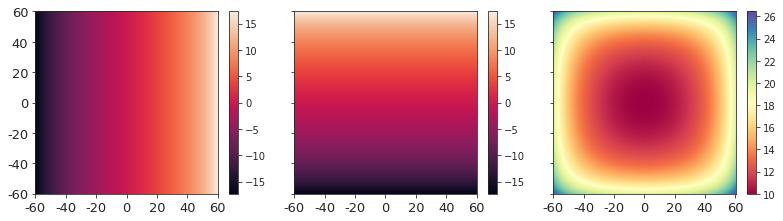

In [7]:
fig, axes = create_figure(1, 3, (11.2, 3.0), 'all', 'all', tight_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(r.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[2])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=13)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
plt.show()

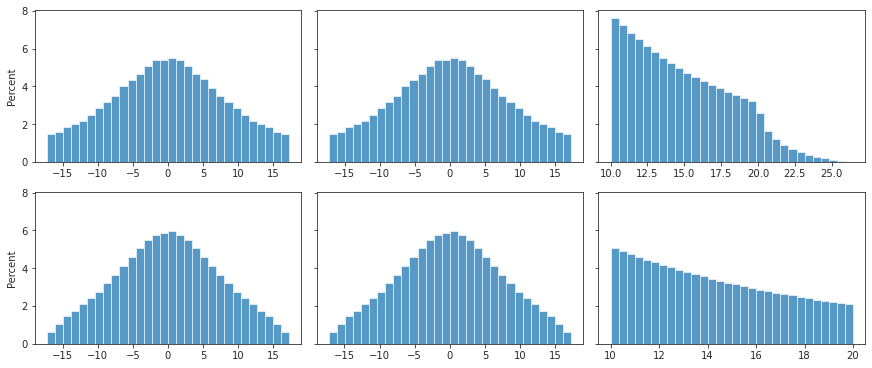

In [8]:
fig, axes = create_figure(2, 3, (12, 5), sharey='all', constrained_layout=True)
sns.histplot(x.ravel(), ax=axes[0, 0], bins=30, stat='percent')
sns.histplot(y.ravel(), ax=axes[0, 1], bins=30, stat='percent')
sns.histplot(r.ravel(), ax=axes[0, 2], bins=30, stat='percent')

sns.histplot(x[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 0], bins=30, stat='percent')
sns.histplot(y[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 1], bins=30, stat='percent')
sns.histplot(r[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 2], bins=30, stat='percent')
plt.show()

### Summary (so far)

- Now I have established a solid relationship between $(\alpha, \beta)$, $(\theta, \phi)$, and $(x, y)$ pairs.
- Maybe -60/+60 is too wide, cosinder narrowing it down.
- Next up: figure out this mapping for arbitrary fixations.
- Finally: differentiate both sides to get anuglar velocities. i.e., $(\dot{\alpha}, \dot{\beta})$.

**Open question:** Resolution requires thinking. Should I choose resolution such that eventually I get $17 \times 17$ (or $33 \times 33$, or $65 \times 65$, etc.), or should I start from fine resolution and apply ```imresize()``` to downsample to arbitrary sizes?

## Arbitrary fixation point

Consider a fixation point
$$\vec{F} = (X_0, Y_0, Z) \equiv (D_0, \Theta_0, \Phi_0),$$
$$D_0 := \sqrt{X_0^2 + Y_0^2 + Z^2}, \cos\Theta_0 = Z/D_0, \tan\Phi_0 = X_0/Y_0.$$

In [9]:
resolution = 0.1
extent = 90
fov = 60

num = int(np.round(2 * extent / resolution)) + 1
span = np.linspace(-extent, extent, num)
span = np.deg2rad(span)
valid = np.abs(span) <= np.deg2rad(fov)

alpha_x, alpha_y = np.meshgrid(span, span)
alpha = np.concatenate([
    np.expand_dims(alpha_x, -1),
    np.expand_dims(alpha_y, -1),
], axis=-1)
theta, phi = get_polar_coords(alpha_x, alpha_y)

In [10]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span[valid]) if i % 200 == 0
])
ticklabels

('-60', '-40', '-20', '0', '20', '40', '60')

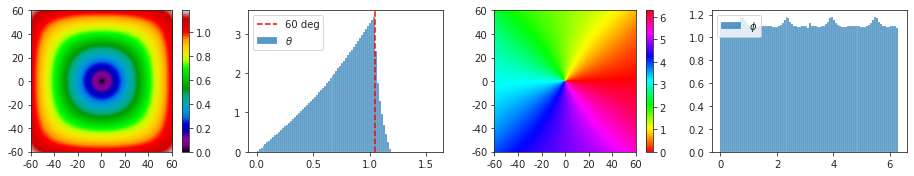

In [11]:
show_thetaphi()

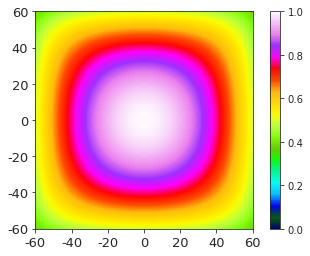

In [12]:
fig, ax = create_figure()
im = ax.imshow(np.cos(theta)[valid][:, valid], cmap='gist_ncar', vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
plt.show()

In [66]:
fix = (4, 0, 10)
d0, theta0, phi0 = cart2polar(fix).ravel()
u0 = (-np.sin(phi0), np.cos(phi0), 0)
u0 = np.array(u0, dtype='float64')
r0 = rot.from_rotvec(theta0 * u0)

gamma = r0.apply(flatten_arr(np.concatenate([
    alpha,
    np.ones((*alpha.shape[:2], 1)),
], axis=-1))).reshape((*alpha.shape[:2], -1))
# d = fix[-1] / (np.cos(theta) * gamma[..., -1])
z = fix[-1] / gamma[..., -1]
x = z * np.tan(alpha_x)
y = z * np.tan(alpha_y)
d = z / np.cos(theta)

d0, theta0, phi0

(10.770329614269007, 0.3805063771123646, 0.0)

In [67]:
np.round(r0.inv().apply(fix), 13), np.round(r0.inv().apply((fix[0], 2, fix[2])), 13)

(array([ 0.        ,  0.        , 10.77032961]),
 array([ 0.        ,  2.        , 10.77032961]))

In [68]:
x = x[valid][:, valid]
y = y[valid][:, valid]
z = z[valid][:, valid]
d = d[valid][:, valid]

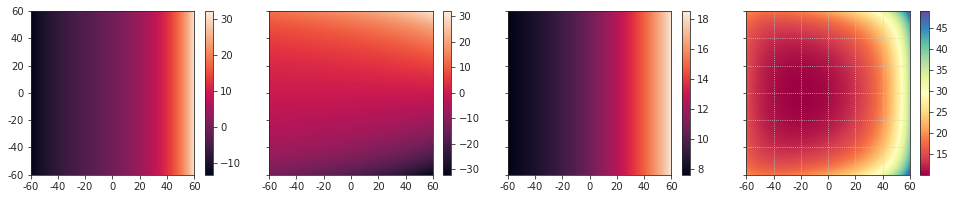

In [69]:
fig, axes = create_figure(1, 4, (13.5, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(z.astype(float))
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(d.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[3])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=10)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
axes[-1].grid()
plt.show()

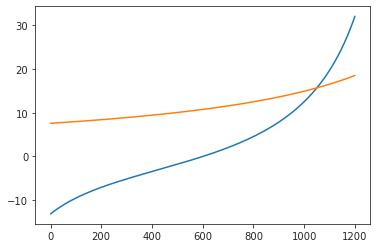

In [78]:
plt.plot(x[0])
plt.plot(z[0])

In [18]:
ids = np.unravel_index(np.argmin(d), d.shape)
ids

(600, 406)

In [19]:
x[ids], y[ids], z[ids]

(-3.3404142597481257, 0.0, 9.485620424212797)

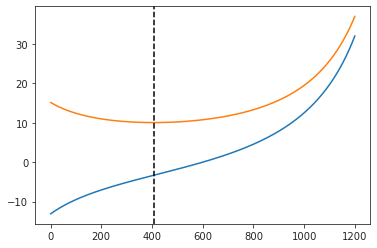

In [26]:
plt.plot(x[600])
plt.plot(d[600])
plt.axvline(406, color='k', ls='--');

In [27]:
np.unravel_index(np.argmax(np.abs(d)), d.shape)

(0, 1200)

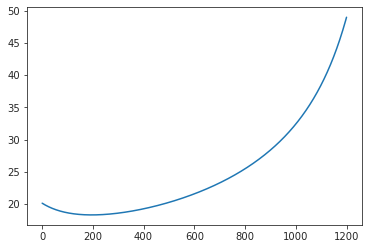

In [28]:
plt.plot(d[0])

In [29]:
d[0, 1200]

49.035596204116295

In [30]:
np.rad2deg(theta[0, 1200])

90.0

In [31]:
span[0], span[1200]

(-1.5707963267948966, 0.5235987755982988)

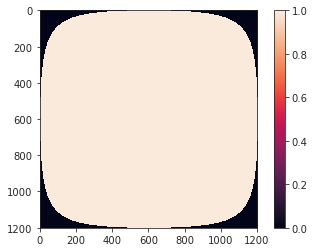

In [32]:
plt.imshow(theta[valid][:, valid] < np.deg2rad(fov))
plt.colorbar()

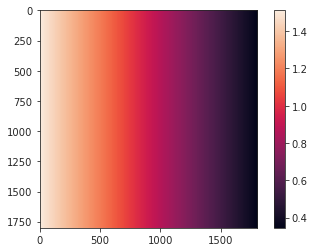

In [46]:
plt.imshow(gamma[..., -1])
plt.colorbar();

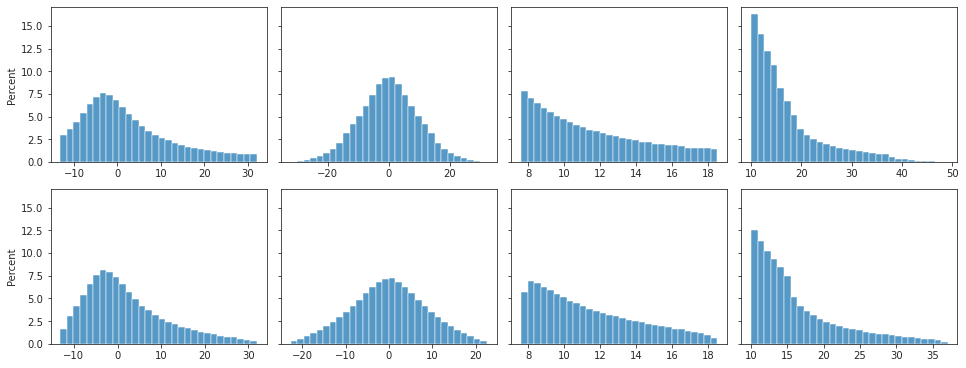

In [47]:
fig, axes = create_figure(2, 4, (13.3, 5), sharey='all', constrained_layout=True)
sns.histplot(x.ravel(), ax=axes[0, 0], bins=30, stat='percent')
sns.histplot(y.ravel(), ax=axes[0, 1], bins=30, stat='percent')
sns.histplot(z.ravel(), ax=axes[0, 2], bins=30, stat='percent')
sns.histplot(d.ravel(), ax=axes[0, 3], bins=30, stat='percent')

sns.histplot(x[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 0], bins=30, stat='percent')
sns.histplot(y[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 1], bins=30, stat='percent')
sns.histplot(z[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 2], bins=30, stat='percent')
sns.histplot(d[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 3], bins=30, stat='percent')
plt.show()

In [48]:
eps = np.sqrt(x**2 + y**2 + z**2) - d
np.round(eps, 13).sum()

0.0

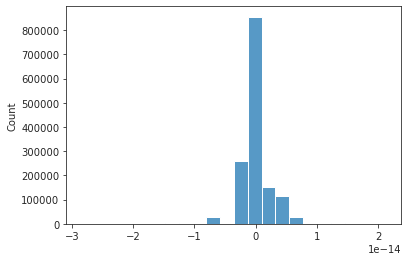

In [49]:
sns.histplot(eps.ravel());

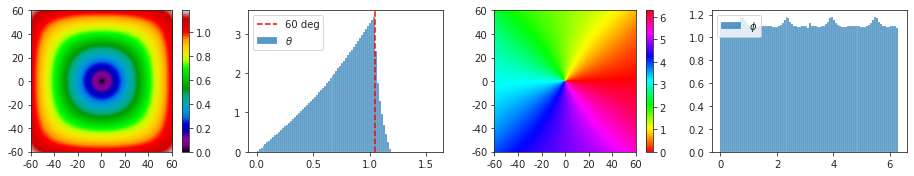

In [50]:
show_thetaphi()

In [67]:
fix = (60, 0, 10)
d0, theta0, phi0 = cart2polar(fix)
u0 = (-np.sin(phi0), np.cos(phi0), 0)
u0 = np.array(u0, dtype='float128')
r0 = rot.from_rotvec(theta0 * u0)

d0, theta0, phi0

(60.8276253029822, 1.4056476493802699, 0.0)

In [71]:
np.rad2deg(np.arctan2(60, 10)), np.rad2deg(theta0), np.rad2deg(phi0)

(80.53767779197439, 80.53767779197439, 0.0)

In [74]:
m = r0.as_matrix()
m

array([[ 0.16439899, -0.        ,  0.98639392],
       [ 0.        ,  1.        ,  0.        ],
       [-0.98639392,  0.        ,  0.16439899]])

In [78]:
aaa = m[2, 0] * np.tan(alpha_x) + m[2, 1] * np.tan(alpha_y) + m[2, 2]
aaa.shape

(1801, 1801)

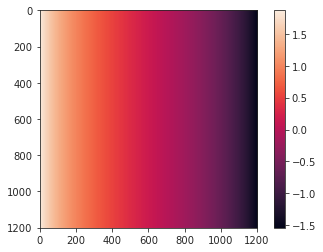

In [80]:
plt.imshow(aaa[valid][:, valid])
plt.colorbar()

In [81]:
bbb = np.cos(theta) * aaa

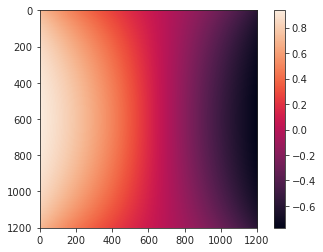

In [83]:
plt.imshow(bbb[valid][:, valid])
plt.colorbar()

In [84]:
ccc = fix[-1] / bbb

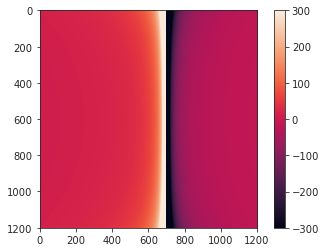

In [91]:
plt.imshow(ccc[valid][:, valid], vmin=-300, vmax=300)
plt.colorbar()

In [92]:
shape = (valid.sum(),) * 2
gamma = r0.apply(flatten_arr(np.concatenate([
    alpha[valid][:, valid],
    np.ones(shape + (1,)),
], axis=-1))).reshape(shape + (-1,))

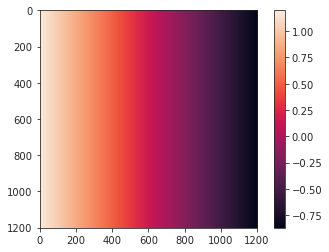

In [94]:
plt.imshow(gamma[..., -1])
plt.colorbar();

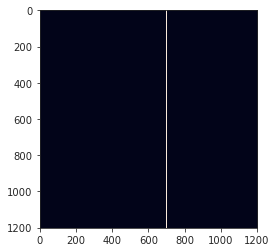

In [95]:
plt.imshow(np.abs(gamma[..., -1]) < 1e-3);

In [97]:
z = fix[-1] / gamma[..., -1]
x = z * np.tan(alpha_x[valid][:, valid])
y = z * np.tan(alpha_y[valid][:, valid])
d = z / np.cos(theta[valid][:, valid])

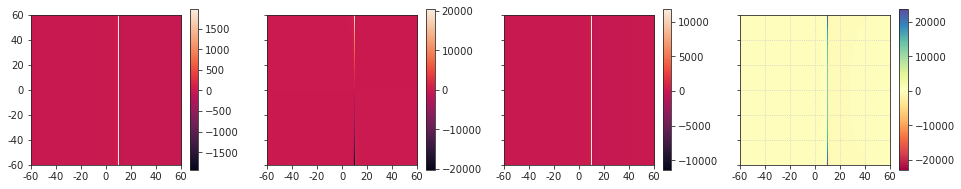

In [99]:
fig, axes = create_figure(1, 4, (13.5, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(z.astype(float))
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(d.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[3])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=10)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
axes[-1].grid()
plt.show()

In [30]:
fix = (60, 0, 10)
d0, theta0, phi0 = cart2polar(fix)
u0 = (-np.sin(phi0), np.cos(phi0), 0)
u0 = np.array(u0, dtype='float128')
r0 = rot.from_rotvec(theta0 * u0)

In [31]:
gamma = np.concatenate([
    np.expand_dims(e, -1) for e in (
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta))
], axis=-1)

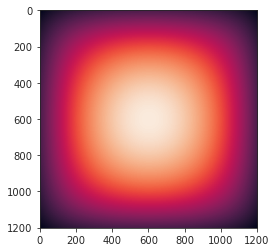

In [32]:
plt.imshow(gamma[..., -1][valid][:, valid]);

In [33]:
d = fix[-1] / gamma[..., -1]
# z = fix[-1] / gamma[..., -1]
z = d * np.cos(theta)
x = z * np.tan(alpha_x)
y = z * np.tan(alpha_y)
# d = z / np.cos(theta)

In [34]:
x = x[valid][:, valid]
y = y[valid][:, valid]
z = z[valid][:, valid]
d = d[valid][:, valid]

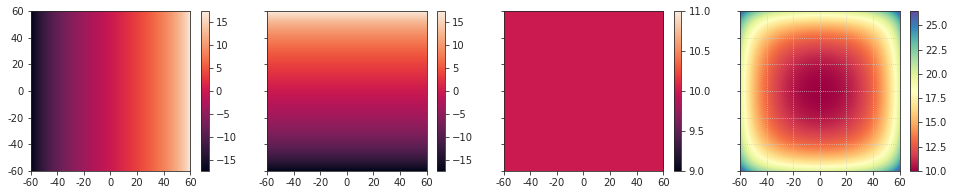

In [35]:
fig, axes = create_figure(1, 4, (13.5, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(z.astype(float))
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(d.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[3])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=10)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
axes[-1].grid()
plt.show()

In [40]:
gamma = np.concatenate([
    np.expand_dims(e, -1) for e in (
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta))
], axis=-1)
gamma = r0.apply(flatten_arr(gamma))
gamma = gamma.reshape((*alpha.shape[:2], -1))

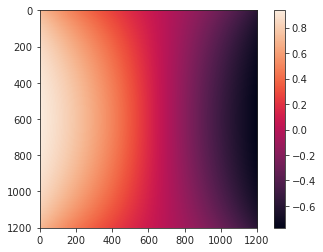

In [43]:
plt.imshow(gamma[..., -1][valid][:, valid])
plt.colorbar();

In [44]:
d = fix[-1] / gamma[..., -1]
# z = fix[-1] / gamma[..., -1]
z = d * np.cos(theta)
x = z * np.tan(alpha_x)
y = z * np.tan(alpha_y)
# d = z / np.cos(theta)

In [45]:
x = x[valid][:, valid]
y = y[valid][:, valid]
z = z[valid][:, valid]
d = d[valid][:, valid]

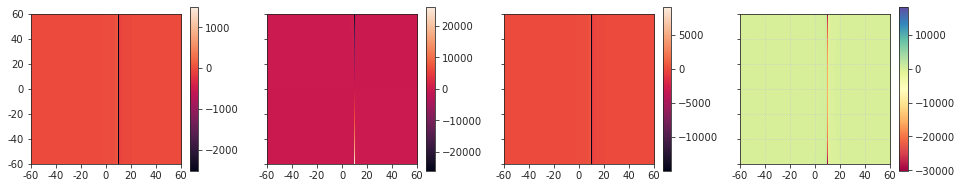

In [46]:
fig, axes = create_figure(1, 4, (13.5, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(z.astype(float))
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(d.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[3])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=10)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
axes[-1].grid()
plt.show()

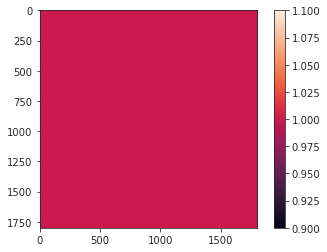

In [50]:
plt.imshow(sp_lin.norm(gamma, ord=2, axis=-1))
plt.colorbar()

In [51]:
e = (1, 0, 0)
e = polar2cart(e)
e = r0.apply(e)
e = cart2polar(e)

e, cart2polar(fix)

(array([[1.        , 0.38050638, 0.        ]]),
 array([[10.77032961,  0.38050638,  0.        ]]))

In [52]:
aaa = polar2cart(np.concatenate([
    np.ones((num, num, 1)),
    np.expand_dims(theta, -1),
    np.expand_dims(phi, -1),
], axis=-1))
aaa.shape

(1801, 1801, 3)

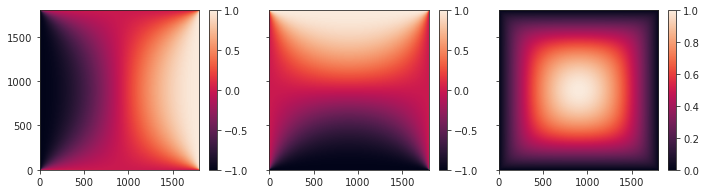

In [53]:
fig, axes = create_figure(1, 3, (10, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(aaa[..., 0])
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(aaa[..., 1])
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(aaa[..., 2])
plt.colorbar(im, ax=axes[2])

axes[-1].invert_yaxis()
plt.show()

In [54]:
fix = (4, 0, 10)
d0, theta0, phi0 = cart2polar(fix).ravel()
u0 = (-np.sin(phi0), np.cos(phi0), 0)
u0 = np.array(u0, dtype='float64')
r0 = rot.from_rotvec(theta0 * u0)

d0, theta0, phi0

(10.770329614269007, 0.3805063771123646, 0.0)

In [55]:
np.round(r0.apply(fix, inverse=True), 13)

array([ 0.        ,  0.        , 10.77032961])

In [56]:
bbb = r0.apply(flatten_arr(aaa))
bbb = bbb.reshape((num, num, -1))
ccc = cart2polar(bbb)

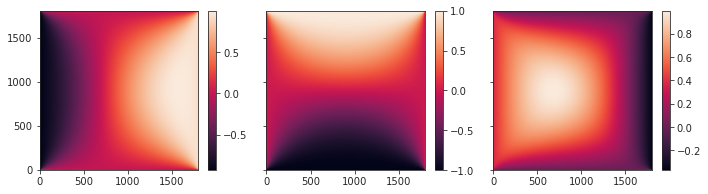

In [57]:
fig, axes = create_figure(1, 3, (10, 2.7), 'all', 'all', tight_layout=True)
im = axes[0].imshow(bbb[..., 0])
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(bbb[..., 1])
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(bbb[..., 2])
plt.colorbar(im, ax=axes[2])

axes[-1].invert_yaxis()
plt.show()

In [58]:
collections.Counter(np.round(ccc[..., 0].ravel(), 14))

Counter({1.0: 3243601})

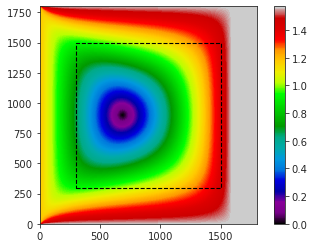

In [59]:
fig, ax = create_figure()
im = ax.imshow(ccc[..., 1], vmin=0, vmax=np.pi/2, cmap='nipy_spectral')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

rect = matplotlib.patches.Rectangle(
    xy=(np.where(valid)[0][0], np.where(valid)[0][0]),
    width=valid.sum(),
    height=valid.sum(),
    facecolor='none',
    edgecolor='k',
    ls='--',
    lw=1.1,
)
ax.add_patch(rect)
plt.show()

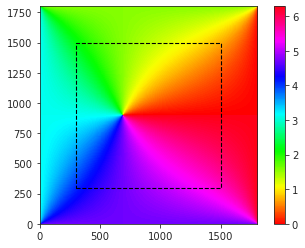

In [60]:
fig, ax = create_figure()
im = ax.imshow(ccc[..., 2], vmin=0, vmax=2*np.pi, cmap='hsv')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

rect = matplotlib.patches.Rectangle(
    xy=(np.where(valid)[0][0], np.where(valid)[0][0]),
    width=valid.sum(),
    height=valid.sum(),
    facecolor='none',
    edgecolor='k',
    ls='--',
    lw=1.1,
)
ax.add_patch(rect)
plt.show()

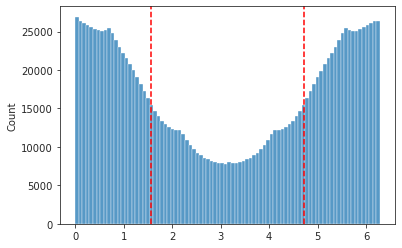

In [63]:
sns.histplot(ccc[..., 2][valid][:, valid].ravel())
plt.axvline(np.pi / 2, color='r', ls='--')
plt.axvline(2 * np.pi - np.pi / 2, color='r', ls='--');

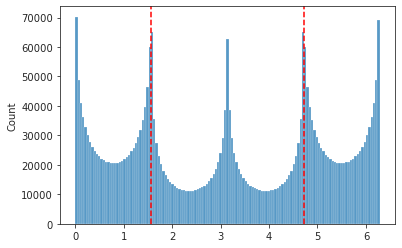

In [64]:
sns.histplot(ccc[..., 2].ravel())
plt.axvline(np.pi / 2, color='r', ls='--')
plt.axvline(2 * np.pi - np.pi / 2, color='r', ls='--');